In [2]:
import numpy as np 
import pandas as pd 
from datetime import date
import holidays
from sklearn.preprocessing import MinMaxScaler # using it to just scale and not for using the models
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import copy
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fetch-daily-data/data_daily.csv


In [3]:

scaler = MinMaxScaler()

# Data loading and Preparation Steps

In [4]:
df=pd.read_csv('/kaggle/input/fetch-daily-data/data_daily.csv')

In [5]:
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [6]:
df['receipt_count']=df['Receipt_Count']
del df['Receipt_Count']

In [7]:
def prepareData(df):
    # I tried to find out the area fetch operates on , I feel its mainly north america.
    # hence US and canada holidays are considered.
    df['date'] = pd.to_datetime(df['# Date'])   
    del df['# Date']
    ca_holidays = holidays.CA(years=2021)
    us_holidays = holidays.US(years=2021)
    h_tag=[]
    dayofweek=[]
    day=[]
    month=[]
    weekofyear=[]
    ind=0
    for i in df['date']:
        dayofweek.append(i.dayofweek)
        day.append(i.day)
        month.append(i.month)
        weekofyear.append(i.weekofyear)
        if i in us_holidays:
            h_tag.append(1)
        elif i in ca_holidays:
            h_tag.append(1)
        else:
            h_tag.append(0)

        ind=ind+1
    df['holidays']=h_tag
    df['day']=day
    df['month']=month
    df['dayofweek']=dayofweek
    df['weekofyear']=weekofyear

In [8]:
features=['day', 'month', 'dayofweek','weekofyear', 'holidays','receipt_count']
prepareData(df)

In [9]:
df.head()

,receipt_count,date,holidays,day,month,dayofweek,weekofyear
0,7564766,2021-01-01,1,1,1,4,53
1,7455524,2021-01-02,0,2,1,5,53
2,7095414,2021-01-03,0,3,1,6,53
3,7666163,2021-01-04,0,4,1,0,1
4,7771289,2021-01-05,0,5,1,1,1


# Data Visualization Step 

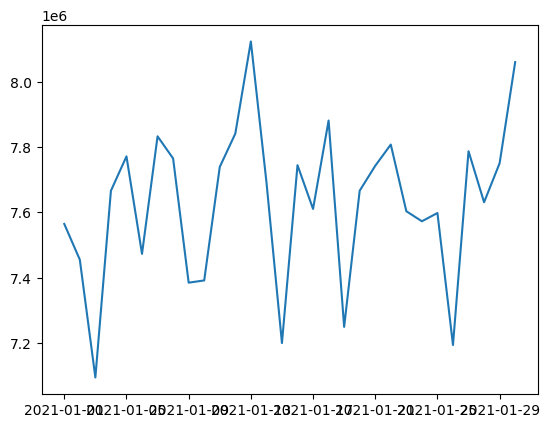

In [10]:
xpoints = np.array(df['date'])
ypoints = np.array(df['receipt_count'])

start=0
end=30
plt.plot(xpoints[start:end], ypoints[start:end])
plt.show()

# Plotting Trend
#### using seasonal decompose on receipt count to see trends and residues in seasonal after trend

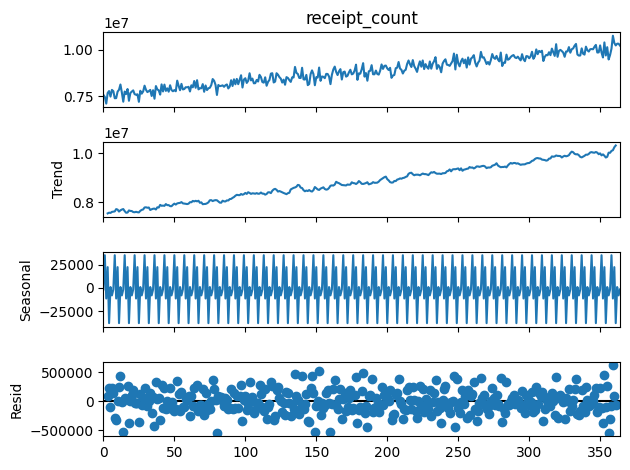

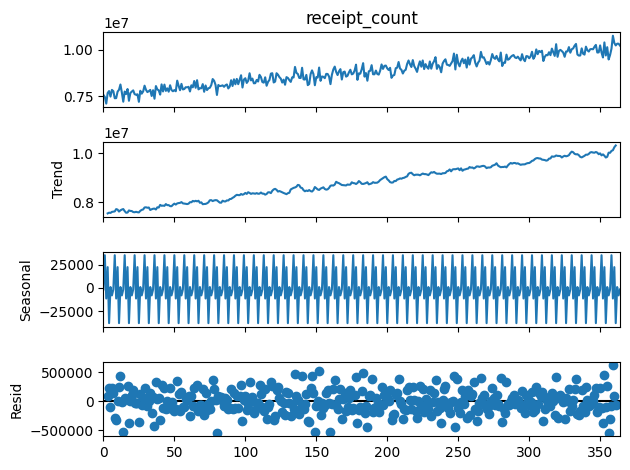

In [11]:
df.index.freq = 'd'
res=seasonal_decompose(x=df['receipt_count'],period=7)
res.plot()

In [12]:
del df['date']

#### using first 11 months for training

In [13]:
xtrain = df.iloc[:365]
xtest = df.iloc[334:]

scaler.fit(xtrain)
strain = scaler.transform(xtrain)
stest = scaler.transform(xtest)

In [14]:
sxtrain=[]
sytrain=[]
sxtest=[]
sytest=[]
for i in strain:
    sxtrain.append(i[:])
    sytrain.append(i[:1])
for i in stest:
    sxtest.append(i[:])
    sytest.append(i[:1])


In [15]:
n_input=7
n_features=6
gen=TimeseriesGenerator(sxtrain,sytrain,length=n_input,batch_size=1)

In [16]:
X,Y=gen[0]

In [17]:
print(X.shape)
print(Y.shape)


(1, 7, 6)
(1, 1)


#### defining the sequential model with LSTM and dense layers with loss function using mean squared error

In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(50))
model.add(Dense(1))

# model.add(Dense(3))

model.compile(optimizer='adam', loss='mse')


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 47901 (187.11 KB)
Trainable params: 47901 (187.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### let's train model for 20 epoch 

In [20]:
model.fit(gen,epochs=20)

Epoch 1/20
358/358 [==============================] - 3s 4ms/step - loss: 0.0075
Epoch 2/20
358/358 [==============================] - 2s 5ms/step - loss: 0.0053
Epoch 3/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0049
Epoch 4/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 5/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 6/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 7/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 8/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 9/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 10/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 11/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 12/20
358/358 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 13/20
358/358 [====

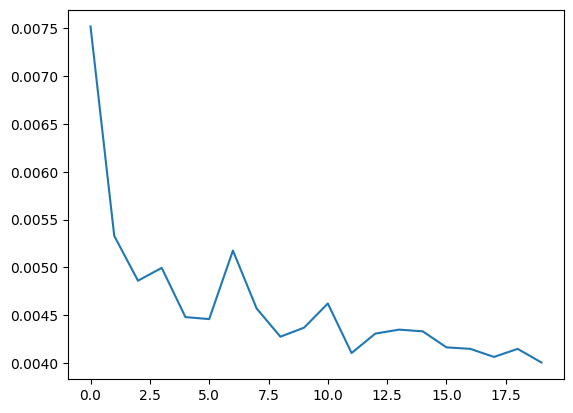

In [21]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [22]:
np.array(sxtest[:7]).shape

(7, 6)

In [23]:
last_train_batch = np.array(sxtest[:n_input])
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
print(model.predict(last_train_batch))

1/1 [==============================] - 0s 173ms/step
[[0.77508956]]


#### making deepcopy to test because going to change it on the go in next steps

In [24]:
sxtest=copy.deepcopy(sxtest)


In [25]:
test_predictions = []
act_predictions=[]
# first_eval_batch = scaled_train[-n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))

first_eval_batch=np.array(sxtrain[-n_input:])
# first_eval_batch=np.array(sxtest[:n_input])
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch)
ind=0
for i in range(len(sxtest)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    act_predictions.append(sytest[ind])
    print()
    print(sytest[ind])
    print(current_pred)
   
    # use the prediction to update the batch and remove the first value
    current_batch=np.delete(current_batch,0,1)
    next_item=sxtest[ind]
    next_item[0]=current_pred
    ind=ind+1
    next_item=next_item.reshape((1, 1, n_features))
    
    current_batch = np.append(current_batch,next_item,axis=1)


[[[0.8098045  1.         0.8        1.         0.83333333 0.96153846]
  [1.         1.         0.83333333 1.         1.         0.96153846]
  [0.89338213 1.         0.86666667 1.         0.         0.98076923]
  [0.85743736 1.         0.9        1.         0.16666667 0.98076923]
  [0.88320743 0.         0.93333333 1.         0.33333333 0.98076923]
  [0.8824683  0.         0.96666667 1.         0.5        0.98076923]
  [0.85517083 1.         1.         1.         0.66666667 0.98076923]]]
1/1 [==============================] - 0s 18ms/step

[0.72354836]
[0.8632575]
1/1 [==============================] - 0s 18ms/step

[0.70777183]
[0.8422859]
1/1 [==============================] - 0s 19ms/step

[0.70923281]
[0.81607723]
1/1 [==============================] - 0s 20ms/step

[0.81391159]
[0.795023]
1/1 [==============================] - 0s 18ms/step

[0.73449403]
[0.78033245]
1/1 [==============================] - 0s 20ms/step

[0.72227375]
[0.7688258]
1/1 [==============================] - 

In [26]:
sytest

[array([0.72354836]),
 array([0.70777183]),
 array([0.70923281]),
 array([0.81391159]),
 array([0.73449403]),
 array([0.72227375]),
 array([0.83914262]),
 array([0.78667807]),
 array([0.76672281]),
 array([0.80163834]),
 array([0.80414338]),
 array([0.80080918]),
 array([0.83698559]),
 array([0.86496456]),
 array([0.7527734]),
 array([0.7549134]),
 array([0.85773131]),
 array([0.75193683]),
 array([0.6798796]),
 array([0.90131334]),
 array([0.70950096]),
 array([0.83130636]),
 array([0.65027497]),
 array([0.71592647]),
 array([0.8098045]),
 array([1.]),
 array([0.89338213]),
 array([0.85743736]),
 array([0.88320743]),
 array([0.8824683]),
 array([0.85517083])]

In [27]:
pred=[]
act=[]
for i in test_predictions:
    pred.append(i)
    
act=[]
for j in sytest[:]:
    act.append(j[0])

In [28]:
res=pd.DataFrame()

In [29]:
res['act']=act
res['pred']=pred[:]

#### act column is actual value and pred column shows predicted value of last month for validation purpose.

In [30]:
res

,act,pred
0,0.723548,0.863258
1,0.707772,0.842286
2,0.709233,0.816077
3,0.813912,0.795023
4,0.734494,0.780332
5,0.722274,0.768826
6,0.839143,0.781790
7,0.786678,0.774786
8,0.766723,0.766712
9,0.801638,0.764861


In [31]:
sxtest_inv=scaler.inverse_transform(sxtest)

In [32]:
sxtest_invdf=pd.DataFrame(sxtest_inv)

In [33]:
abs( sum(df[df.month==12]['receipt_count']) - sum(sxtest_invdf[0]) ) *100/ sum(df[df.month==12]['receipt_count'])

0.006010400722775115

<Axes: >

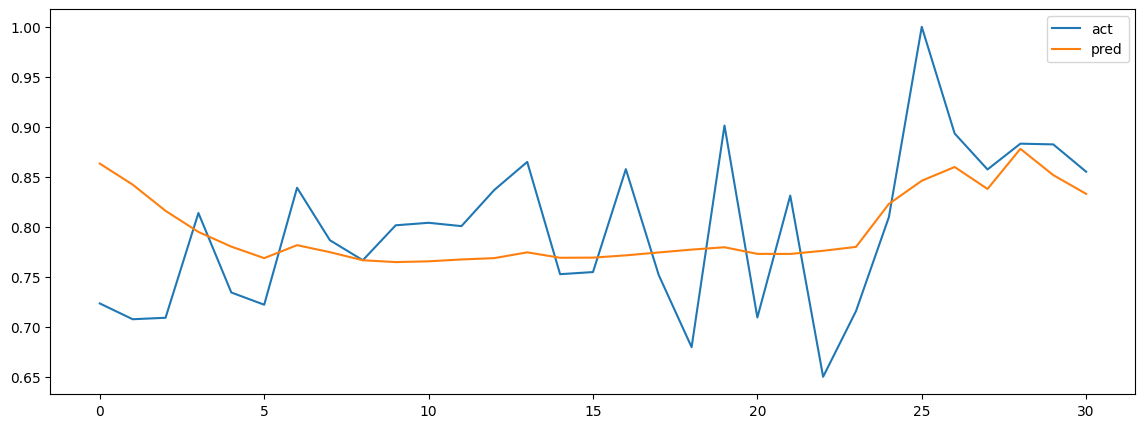

In [34]:
res.plot(figsize=(14,5))


In [35]:
futureDf=pd.DataFrame()
futureDf['# Date']=pd.date_range('2022-01-01', '2022-12-31', freq='D')

In [36]:
futureDf
futureDf['receipt_count']=None


In [37]:
prepareData(futureDf)

In [38]:
futureDf

,receipt_count,date,holidays,day,month,dayofweek,weekofyear
0,None,2022-01-01,1,1,1,5,52
1,None,2022-01-02,0,2,1,6,52
2,None,2022-01-03,1,3,1,0,1
3,None,2022-01-04,0,4,1,1,1
4,None,2022-01-05,0,5,1,2,1
...,...,...,...,...,...,...,...
360,None,2022-12-27,1,27,12,1,52
361,None,2022-12-28,0,28,12,2,52
362,None,2022-12-29,0,29,12,3,52
363,None,2022-12-30,0,30,12,4,52


In [39]:
del futureDf['date']

In [40]:
futureDf['month']=futureDf['month']+12
futureDf.loc[2:, 'weekofyear'] = futureDf.loc[2:, 'weekofyear'] + 52

In [41]:
futureDf.head()

,receipt_count,holidays,day,month,dayofweek,weekofyear
0,None,1,1,13,5,52
1,None,0,2,13,6,52
2,None,1,3,13,0,53
3,None,0,4,13,1,53
4,None,0,5,13,2,53


In [42]:
sfuture=scaler.transform(futureDf)

In [43]:
future_pred = []


first_eval_batch=np.array(sxtrain[-n_input:])
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# print(current_batch)
ind=0
for i in range(len(sfuture)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
#     print(current_pred)
    # append the prediction into the array
    future_pred.append(current_pred[0]) 
#     print()
#     print(current_pred)
   
    # use the prediction to update the batch and remove the first value
    
    current_batch=np.delete(current_batch,0,1)
    next_item=sfuture[ind]
    next_item[0]=current_pred
    ind=ind+1
    next_item=next_item.reshape((1, 1, n_features))
    
    current_batch = np.append(current_batch,next_item,axis=1)


1/1 [==============================] - 0s 19ms/step


In [44]:
future_pred

[0.8632575,
 0.8960179,
 0.8660528,
 0.9289054,
 0.886248,
 0.85689586,
 0.8361964,
 0.8227756,
 0.82397264,
 0.82326466,
 0.83591664,
 0.8305079,
 0.8245997,
 0.8241871,
 0.8261235,
 0.82862514,
 0.83172125,
 0.88294846,
 0.85909545,
 0.8489403,
 0.8448799,
 0.84378844,
 0.8440882,
 0.84560686,
 0.8319019,
 0.83360165,
 0.83736676,
 0.8415276,
 0.84545815,
 0.84888196,
 0.8522963,
 0.83763963,
 0.89512897,
 0.893798,
 0.8834302,
 0.8775339,
 0.87466407,
 0.8743075,
 0.895,
 0.8902208,
 0.88074523,
 0.8773576,
 0.8775158,
 0.87944615,
 0.88256,
 0.89248544,
 0.8866143,
 0.8835117,
 0.88467115,
 0.8874189,
 0.8903859,
 0.893856,
 0.9427011,
 0.9198215,
 0.9105054,
 0.90688086,
 0.9060415,
 0.90644795,
 0.90821475,
 0.89148706,
 0.95051134,
 0.9482704,
 0.9376555,
 0.9300478,
 0.92677593,
 0.9264754,
 0.9508088,
 0.9457758,
 0.9361744,
 0.93089074,
 0.93046653,
 0.9323062,
 0.93562806,
 0.9485734,
 0.9425514,
 0.93753344,
 0.938032,
 0.9407232,
 0.9437771,
 0.94748443,
 0.9464965,
 0.941

In [45]:
final_future=scaler.inverse_transform(sfuture)

In [46]:
final_future=pd.DataFrame(final_future,columns=['receipt_count','holidays','day','month','dayofweek','weekofyear'])

In [47]:
result = final_future.groupby('month').agg({'receipt_count': 'sum'}).reset_index()
df_preyear=df.groupby('month').agg({'receipt_count': 'sum'}).reset_index()

In [48]:
result = pd.concat([ df_preyear,result], axis=0)

<Axes: xlabel='month'>

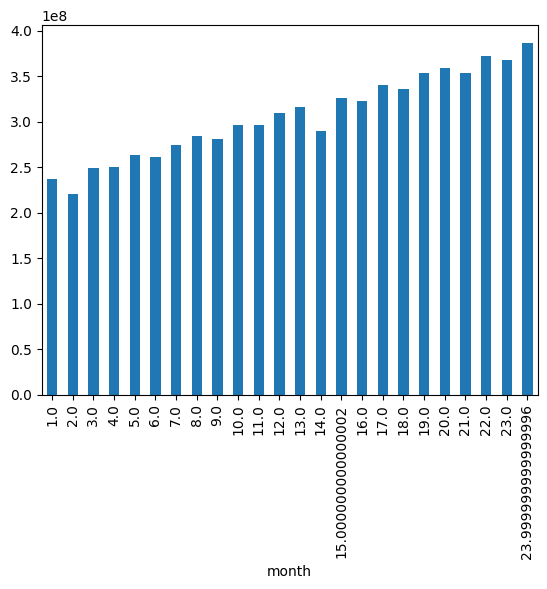

In [49]:
result.plot(kind='bar', x='month', y='receipt_count', legend=False)

## month 13 onwards are of next year predictions

In [50]:
pd.options.display.float_format = '{:.0f}'.format
result

,month,receipt_count
0,1,236736687
1,2,220033460
2,3,248608625
3,4,250644830
4,5,263151748
5,6,260656840
6,7,274776003
7,8,283943231
8,9,281146154
9,10,295965185


In [51]:
from joblib import dump, load
dump(scaler, 'receipt_scaler.joblib')
model.save('fetch_model.keras')